In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
filename = 'USDCLP.xlsx'
data = pd.read_excel(filename, skiprows=4, index_col='Dates', parse_dates=True)
data.dropna(inplace=True)
data.columns = ['Open', 'High', 'Low', 'Close']
data = data['2006-01':] # before 2004 the data is not OHLC, but C
data.head()
data['2018-01-08':'2018-01-13']

,Open,High,Low,Close
Dates,,,,
2018-01-08,606.37,608.47,604.58,605.31
2018-01-09,606.00,608.59,605.57,607.89
2018-01-10,607.66,610.70,606.23,609.32
2018-01-11,608.01,609.67,606.13,606.22
2018-01-12,603.17,605.81,602.86,603.18


In [4]:
train_size = 150
test_size = 50
return_day = 10
full_size = train_size + test_size + return_day
# make return_day long gap between train and test set to avoid lookahead bias

# rolling_std_dev_size = 40
extreme_multiplier = 0

In [5]:
new_data = data.resample('1W').pad()
new_data['Open'] = data['Open'].resample('1W').first()
new_data['Close'] = data['Close'].resample('1W').last()
new_data['High'] = data['High'].resample('1W').max()
new_data['Low'] = data['Low'].resample('1W').min()
new_data.dropna(inplace=True)
new_data.tail()

,Open,High,Low,Close
Dates,,,,
2018-01-07,612.19,612.45,601.80,605.78
2018-01-14,606.37,610.70,602.86,603.18
2018-01-21,599.58,608.82,599.31,608.21
2018-01-28,607.69,609.78,597.70,601.68
2018-02-04,603.65,607.37,596.31,597.03


In [6]:
data = new_data

In [7]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

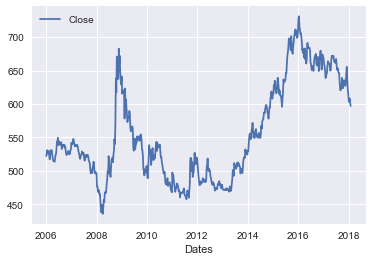

In [8]:
data['2006-01':][['Close']].plot()

In [9]:
features_to_delete = data.columns.tolist()

# ROC

In [10]:
for i in [2, 5, 10, 20, 30]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

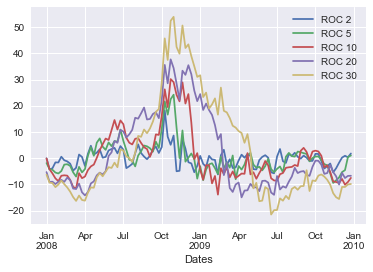

In [11]:
data['2008': '2009'][['ROC 2', 'ROC 5', 'ROC 10', 'ROC 20', 'ROC 30']].plot()

# Deviation from zero-lag exponential MA

In [12]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

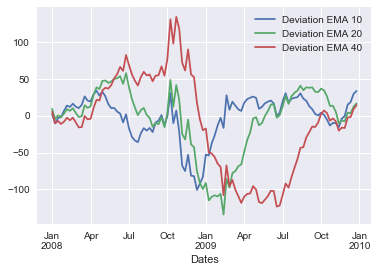

In [13]:
data['2008':'2009'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [14]:
for i, j, k in [(14, 20, 12), (12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd

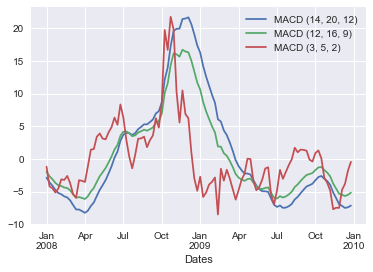

In [15]:
data['2008':'2009'][['MACD (14, 20, 12)', 'MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

# RSI

In [16]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

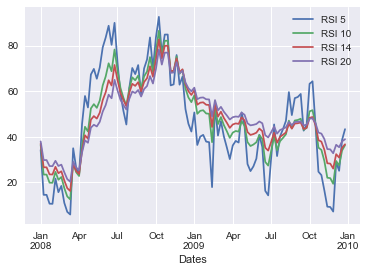

In [17]:
data['2008':'2009'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [18]:
for i, j in [(5, 10), (10, 20), (20, 40)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

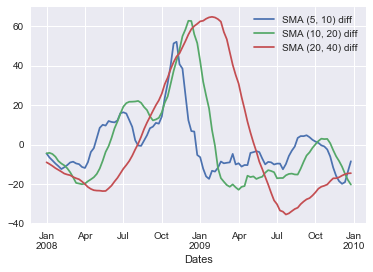

In [19]:
data['2008':'2009'][['SMA (5, 10) diff', 'SMA (10, 20) diff', 'SMA (20, 40) diff']].plot()

# ADX: Average directional index

In [20]:
data['ADX 20'] = tl.ADX(high, low, close, timeperiod=20)
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)
data['ADX 7'] = tl.ADX(high, low, close, timeperiod=7)

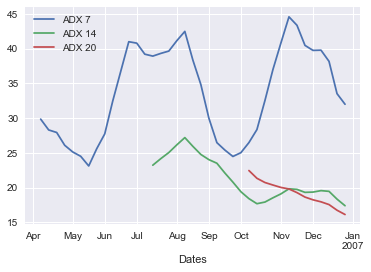

In [21]:
data['2005':'2006'][['ADX 7', 'ADX 14', 'ADX 20']].plot()

# CCI: Commodity Channel Index

In [22]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

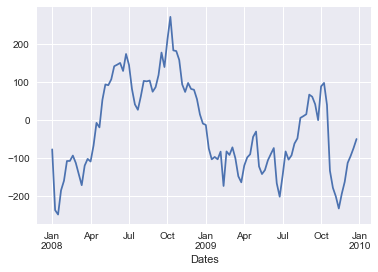

In [23]:
data['2008':'2009']['CCI 14'].plot()

# STD deviation 20 = Bollinger Bands (20)

In [24]:
data['Std dev 10'] = tl.STDDEV(close, timeperiod=10)
data['Std dev 20'] = tl.STDDEV(close, timeperiod=20)

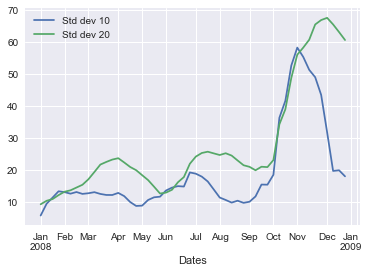

In [25]:
data['2008'][['Std dev 10', 'Std dev 20']].plot()

# Y target value

In [26]:
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Return scaled'] = data['Return'] / (data['Return'].rolling(return_day).std().fillna(1.0))

In [27]:
data.dropna(inplace=True)
data.drop(labels=features_to_delete, inplace=True, axis=1)
data.head()

,ROC 2,ROC 5,ROC 10,ROC 20,ROC 30,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (14, 20, 12)","MACD (12, 16, 9)",...,"SMA (10, 20) diff","SMA (20, 40) diff",ADX 20,ADX 14,ADX 7,CCI 14,Std dev 10,Std dev 20,Return,Return scaled
Dates,,,,,,,,,,,,,,,,,,,,,
2006-10-08,-0.380228,-0.158007,-0.380228,2.519565,1.177357,-0.121162,-14.330774,-2.643500,0.863213,0.499993,...,-0.7925,7.88075,22.459781,18.420776,26.475325,-77.651909,2.891914,5.154992,-2.178365,-4.622072
2006-10-15,-0.659776,-1.433526,-2.018619,1.257382,0.710564,-2.690042,-18.661177,-8.292598,0.561771,0.224931,...,-2.2175,7.97950,21.345071,17.692026,28.352164,-123.336829,3.097586,4.406573,-0.047037,-0.058278
2006-10-22,-2.075964,-2.094192,-3.095348,-1.137218,-0.962226,-3.687307,-21.329160,-13.177105,0.106841,-0.185409,...,-3.5950,7.67200,20.738684,17.927916,32.522445,-203.482817,3.955128,5.051440,1.216846,1.036234
2006-10-29,-1.467545,-2.865622,-1.696888,-3.687356,-0.503467,-3.214160,-19.424002,-14.316027,-0.336954,-0.569863,...,-3.4965,6.85325,20.375245,18.539290,36.989996,-218.790097,5.257808,5.907448,3.488639,1.784633
2006-11-05,-0.066546,-1.762518,-2.168450,-3.417861,0.970128,1.042960,-14.083621,-11.785977,-0.608285,-0.777806,...,-3.7315,5.93575,20.029978,19.106994,40.819325,-151.857612,5.764811,6.294258,2.612253,1.188911


# Features

In [28]:
feature_names = data.drop(['Return', 'Return scaled'], axis=1).columns

# Train and test Random Forest

In [29]:
def to_class(y_vec):
#     y_extreme = extreme_multiplier * y_vec.rolling(rolling_std_dev_size).std().fillna(method='bfill')
    
    pos = y_vec > extreme_multiplier
    neg = y_vec < -1*extreme_multiplier

    y_vec[:] = 'Neutral'
    y_vec[pos] = 'Pos'
    y_vec[neg] = 'Neg'
    return y_vec

In [30]:
def make_X_y(df):
    X = df.drop(['Return', 'Return scaled'], axis=1)
    y = df['Return'].copy()
    ret = y.copy()
    y = to_class(y)
    return X, y, ret

In [31]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[-test_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[-test_size:]
    train_ret = ret.iloc[:train_size]
    test_ret = ret.iloc[-test_size:]
    print('Split result before upsampling: {} -> {} + {}'.format(len(X), len(X_train), len(X_test)))
    
    last_q4 = int(train_size/4)
    last_q8 = int(train_size/8)
    last_q16 = int(train_size/16)
    
    X_train = pd.concat([X_train, X_train[-last_q4:], X_train[-last_q8:], X_train[-last_q16:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-last_q4:], y_train[-last_q8:], y_train[-last_q16:]], ignore_index=True)
    train_ret = pd.concat([train_ret, train_ret[-last_q4:], train_ret[-last_q8:], train_ret[-last_q16:]], ignore_index=True)
    
    return X_train, X_test, y_train, y_test, train_ret, test_ret

In [32]:
def print_labels_distrib(y_train, y_test):
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)

In [33]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred):
    bad = ((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos'))
    bad_sum = -20*np.sum(bad)
    avg = ((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg'))
    avg_sum = -2*np.sum(avg)
    good = ((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg'))
    good_sum = 7*np.sum(good)
    return bad_sum + good_sum
scorer = make_scorer(custom_loss, greater_is_better=True)

In [34]:
def calculate_returns(ret, y_pred):
    pos = (y_pred == 'Pos')
    neg = (y_pred == 'Neg')
    
    longs = np.nansum(ret[pos])
    shorts = np.nansum(-1*ret[neg])
    
    ret_sum = longs + shorts
    print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
    
    ret2 = ret.copy()
    ret2.iloc[:] = np.nan
    ret2[pos] = ret[pos]
    ret2[neg] = -1*ret[neg]
    ret2.dropna(inplace=True)
    
    return ret_sum, ret2

In [35]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

# Train and Test

In [52]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, train_ret, test_ret = split_X_y(X, y, ret)
    print_labels_distrib(y_train, y_test)
    
    forest = RandomForestClassifier(n_jobs=8, class_weight='balanced_subsample')
    pipe = Pipeline(steps=[('scaler', StandardScaler()), 
#                            ('pca', PCA()), 
                           ('forest', forest)])
    
    params = {'forest__n_estimators': [50],
              'forest__max_depth': [3, None],
              'forest__max_features': [3,4],
              'forest__min_samples_split': [2,3,5],
              'forest__min_samples_leaf': [2,5,10],
#               'pca__n_components': [0.3, 0.7]
             }
    grid = GridSearchCV(estimator=pipe,
                        param_grid=params, 
                        scoring='accuracy',
                        cv=6)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum, trades = calculate_returns(test_ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.index[-1],
        'best_params': best_params,
        'features': best_estimator.steps[-1][1].feature_importances_,
        'ret_sum': ret_sum,
        'trades': trades
    }
    test_params.append(param)

In [53]:
test_params = []

for i in range(0, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1] #mit jelent az index[-1]?
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

From 2006-10-08 00:00:00 to 2010-10-10 00:00:00
Split result before upsampling: 210 -> 150 + 50
---
Distribution:
Neg    138
Pos     76
Name: Return, dtype: int64
---
Distribution:
Neg    29
Pos    21
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.77      0.83      0.80        29
        Pos       0.74      0.67      0.70        21

avg / total       0.76      0.76      0.76        50

---
Confusion matrix
 [[24  5]
 [ 7 14]]
51.71601573977259 [long] + 98.28242801206368 [short] = 149.99844375183625
From 2007-09-23 00:00:00 to 2011-09-25 00:00:00
Split result before upsampling: 210 -> 150 + 50
---
Distribution:
Neg    126
Pos     88
Name: Return, dtype: int64
---
Distribution:
Neg    26
Pos    24
Name: Return, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.52      1.00      0.68        26
        Pos       0.00      0.00      0.00        24

avg / total       0.27      0.52      0.36        50

---
Confusion matrix
 [[26  0]
 [24  0]]
0.0 [long] + -62.084845800209294 [short] = -62.084845800209294
From 2008-09-07 00:00:00 to 2012-09-09 00:00:00
Split result before upsampling: 210 -> 150 + 50
---
Distribution:
Neg    137
Pos     77
Name: Return, dtype: int64
---
Distribution:
Neg    31
Pos    19
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.61      0.87      0.72        31
        Pos       0.33      0.11      0.16        19

avg / total       0.51      0.58      0.51        50

---
Confusion matrix
 [[27  4]
 [17  2]]
-12.946475852572213 [long] + 48.52445239321018 [short] = 35.57797654063797
From 2009-08-23 00:00:00 to 2013-08-25 00:00:00
Split result before 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
indexes = [d['date'] for d in test_params]

# Random Forest parameters with Accuracy and Returns

In [55]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [56]:
params.sort_values('Sum of return', ascending=False)

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
2015-07-26,NaN,3,2,2,50,156.374798,0.78
2010-10-10,3.0,3,5,2,50,149.998444,0.76
2013-08-25,3.0,3,5,3,50,47.353703,0.58
2012-09-09,NaN,4,2,5,50,35.577977,0.58
2016-07-10,NaN,4,2,2,50,-5.574427,0.46
2017-06-25,NaN,3,2,3,50,-15.981577,0.56
2011-09-25,NaN,3,2,2,50,-62.084846,0.52
2014-08-10,NaN,3,2,5,50,-67.697152,0.36


In [57]:
params.describe()

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
count,2.0,8.00000,8.00000,8.000000,8.0,8.000000,8.000000
mean,3.0,3.25000,2.75000,3.000000,50.0,29.745865,0.575000
std,0.0,0.46291,1.38873,1.309307,0.0,86.277097,0.140915
min,3.0,3.00000,2.00000,2.000000,50.0,-67.697152,0.360000
25%,3.0,3.00000,2.00000,2.000000,50.0,-27.507394,0.505000
50%,3.0,3.00000,2.00000,2.500000,50.0,15.001775,0.570000
75%,3.0,3.25000,2.75000,3.500000,50.0,73.014889,0.625000
max,3.0,4.00000,5.00000,5.000000,50.0,156.374798,0.780000


In [58]:
#params['Accuracy'].plot()

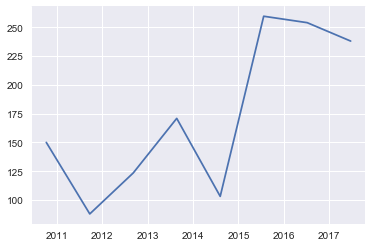

In [59]:
params['Sum of return'].cumsum().plot()

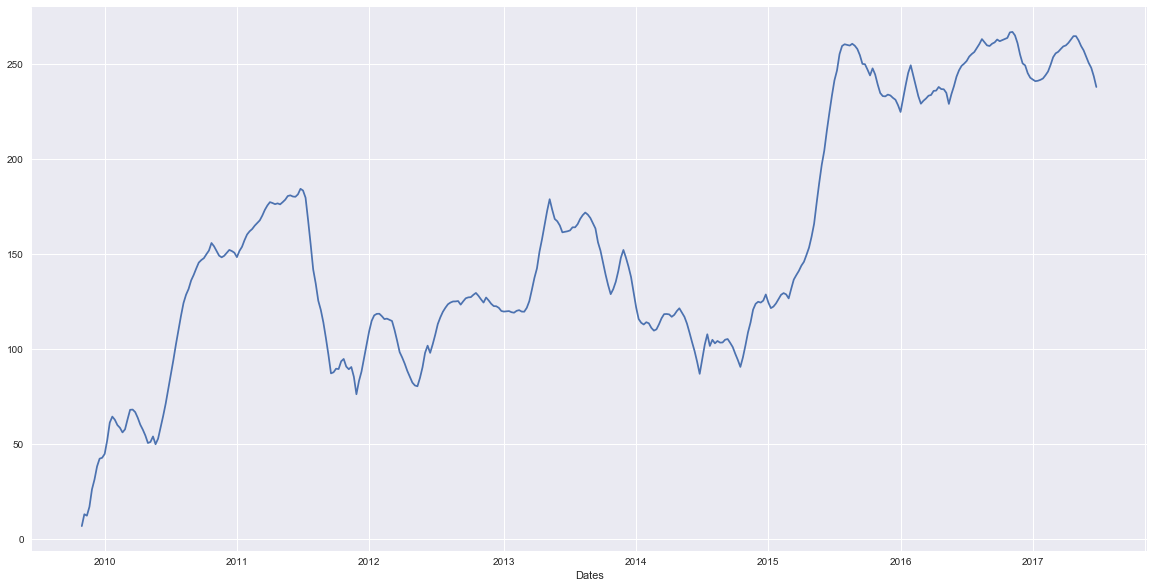

In [60]:
all_trades = pd.concat([d['trades'] for d in test_params], axis=0)
all_trades.cumsum().plot(figsize=(20,10))

In [61]:
all_trades['2010'].groupby(by=lambda x: x.month).count()

1     5
2     4
3     4
4     4
5     5
6     4
7     4
8     5
9     4
10    5
11    4
12    4
Name: Return, dtype: int64

In [62]:
all_trades['2010-08']

Dates
2010-08-01    7.514628
2010-08-08    6.800459
2010-08-15    4.371799
2010-08-22    3.042616
2010-08-29    4.470447
Name: Return, dtype: float64

In [63]:
all_trades.groupby(by=lambda x: x.year).count()

2009     9
2010    52
2011    52
2012    53
2013    52
2014    52
2015    52
2016    52
2017    26
Name: Return, dtype: int64

In [64]:
features = pd.DataFrame([d['features'] for d in test_params], index=indexes, columns=feature_names)

In [65]:
features.idxmax(axis=1).value_counts()

SMA (10, 20) diff    2
Std dev 10           1
RSI 14               1
Deviation EMA 20     1
RSI 20               1
SMA (20, 40) diff    1
Std dev 20           1
dtype: int64

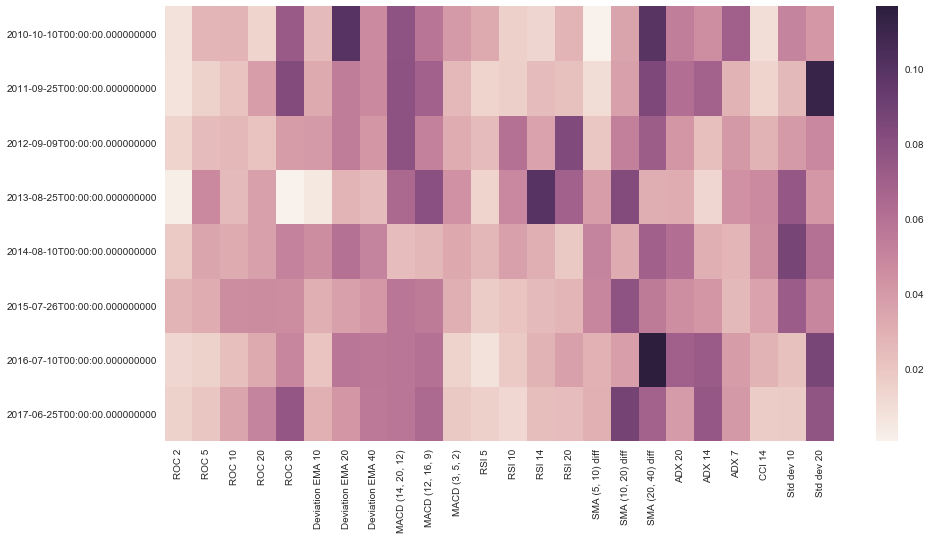

In [66]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


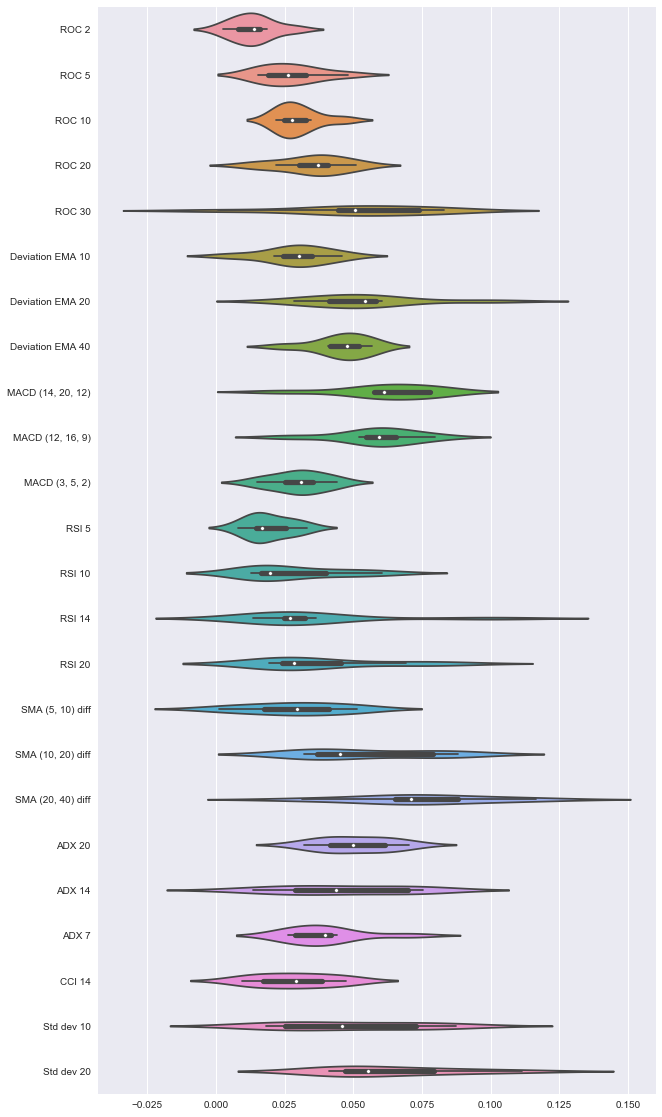

In [67]:
plt.figure(figsize=(10,20))
sns.violinplot(data=features, orient='h')